## Load Parameters & Other Essentials

### Load the Training Dataset

In [1]:
dataset_file = './trainingdata_stepwise_turkish_3_articulators.tsv'

### Load the packages and functions

In [2]:
from dev import *
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm

data_stepwise = Dataset(dataset_file)

./trainingdata_stepwise_turkish_3_articulators.tsv


/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most r

## Evaluation Data Preparation

### Define the articulators to be used by different models

In [3]:
rounding = ["la_output", "tb_output"]
round_and_front = ["la_output", "tb_output", "tc_output"]
front = ["tb_output", "tc_output"]
analyses = [rounding, round_and_front, front]

def get_analysis_name(ls: list) -> str:
    if ls == rounding:
        return 'rounding'
    if ls == round_and_front:
        return 'round_and_front'
    if ls == front:
        return 'fronting'

# load dataframe
data = pd.read_csv(dataset_file, sep='\t')
data = data[data['syllables']==2]

### Create several models for each analysis and construct a dataframe

In [22]:
# define functions to be used when building the dataframe

# helper function to get decoder outputs
def get_decoder(input: torch.Tensor, target: torch.Tensor, model) -> np.ndarray:
    with torch.no_grad():
        predicted, attn_map_seq = model(input, target)
        # don't reduce since we want to know the loss at various time steps
        loss = torch.nn.functional.mse_loss(predicted.float(), target.float(), reduction='none')
        loss_art_avg = torch.mean(loss, 1)
    return loss_art_avg.numpy(), attn_map_seq.numpy()[:,0] # attention paid to the first letter

# helper functions to get correct inputs
def get_trial(training_data, word, model):
    trial = training_data.make_trial(word)
    target_values = []
    target_dict = {'la_output':1, 'tb_output':2, 'tc_output':3}
    for art in model.articulators:
        target_values.append(trial[target_dict[art]]) # get the articulators relevant to the output
    target = torch.cat(tuple(target_values), 1)
    return trial[0], target, model

# get the decoder outputs for each word
def get_values(x, y, model):
    pred, attn = get_decoder(*get_trial(x, y, model))
    df = pd.concat((pd.DataFrame(pred), pd.DataFrame(attn)))
    cols = ['loss' + str(i) for i in range(10)]
    cols.extend([i for i in range(10)])
    df = df.set_axis(cols, axis=0, inplace=False)
    return df

LOAD_MODELS = True
NO_MODELS = 20
NO_EPOCHS = 200

# iterate through each analysis
df_all = None
for k, analysis in enumerate(analyses):
    # iterate over 20 different models
    for j in range(NO_MODELS):
        # train a new model
        if LOAD_MODELS:
            analysis_str = "_".join([s[0:2] for s in analysis])
            save_file = f"saved_models/gestnet_{analysis_str}_{j+1}_{NO_EPOCHS}.pt"
            model = Seq2Seq(load=save_file, articulators=analysis)
            avg_loss = model.evaluate_model(training_data=data_stepwise)
            print(f"Avg Loss (MSE): {avg_loss}")
        else:
            model = Seq2Seq(training_data=data_stepwise, articulators=analysis)
            model.train_model(training_data=data_stepwise, n_epochs=NO_EPOCHS)
            model.save()
            avg_loss = model.evaluate_model(training_data=data_stepwise)
            print(f"Avg Loss (MSE): {avg_loss}")

        model.eval()

        # get the attention values from the model
        df = get_values(data_stepwise, data['underlying'].values[0], model).T
        for i in range(1, data['underlying'].shape[0]):
            df = pd.concat(
                (df, get_values(data_stepwise, data['underlying'].values[i], model).T),
                axis=0
            )

        # reset the indexes
        df = df.reset_index().drop('index', axis=1)

        # add columns
        for c in ['underlying', 'consonant', 'vowel']:
            col = data[c]
            col = col.reset_index().drop('index', axis=1)
            df[c] = col

        df = df.rename({'vowel': "V2"}, axis=1)
        df = df.assign(
            V1 = lambda d: d['underlying'].astype(str).str[0]
        )

        df = df.assign(
            group = get_analysis_name(analysis)
        )

        df = df.assign(
            model = (j+1) + (k * NO_MODELS)
        )
    
        if isinstance(df_all, pd.DataFrame):
            df_all = pd.concat((df_all, df), axis=0)
        else:
            df_all = df

        print(end='\x1b[2K')
        print(f"{(j+1) + (k * NO_MODELS)}/{NO_MODELS * len(analyses)}")

df_all = df_all.reset_index().drop('index', axis=1)
print(df_all)

Average loss per word this epoch:0.057446709354634445
Avg Loss (MSE): 0.057446709354634445
1/60
Average loss per word this epoch:0.06622730906140835
Avg Loss (MSE): 0.06622730906140835
2/60
Average loss per word this epoch:0.08115574772576413
Avg Loss (MSE): 0.08115574772576413
3/60
Average loss per word this epoch:0.05392624466266069
Avg Loss (MSE): 0.05392624466266069
4/60
Average loss per word this epoch:0.05929475436924905
Avg Loss (MSE): 0.05929475436924905
5/60
Average loss per word this epoch:0.06321435394622515
Avg Loss (MSE): 0.06321435394622515
6/60
Average loss per word this epoch:0.058809332780785754
Avg Loss (MSE): 0.058809332780785754
7/60
Average loss per word this epoch:0.07145045800037526
Avg Loss (MSE): 0.07145045800037526
8/60
Average loss per word this epoch:0.07027156508896344
Avg Loss (MSE): 0.07027156508896344
9/60
Average loss per word this epoch:0.06649722061411012
Avg Loss (MSE): 0.06649722061411012
10/60
Average loss per word this epoch:0.06719929282230118
Av

### Prep dataframe for analysis

In [5]:
# create additional categorical values
df_a = df_all.assign(
    rounded = lambda d: d["V1"].apply(lambda y: 1 if y in ["ø", "u", "y", "o"] else 0)
)
df_b = df_a.assign(
    fronted = lambda d: d["V1"].apply(lambda y: 1 if y in ["ø", "e", "y", "i"] else 0)
)
df_c = df_b.assign(
    high = lambda d: d["V1"].apply(lambda y: 1 if y in["ø", "u", "y", "o", "i", "ɯ"] else 0)
)
print(df_c)

         loss0     loss1     loss2     loss3     loss4         loss5  \
0     0.002835  0.000621  0.002076  0.003621  0.002590  6.635665e-04   
1     0.004079  0.002682  0.002654  0.001711  0.006751  2.867466e-03   
2     0.001881  0.000345  0.001939  0.005955  0.003913  3.462725e-03   
3     0.000141  0.007913  0.000530  0.002575  0.000373  8.000014e-04   
4     0.001179  0.005992  0.003287  0.003671  0.000216  5.694532e-04   
...        ...       ...       ...       ...       ...           ...   
2875  0.000159  0.000013  0.000237  0.002475  0.001536  3.696090e-03   
2876  0.000133  0.000238  0.000830  0.001239  0.000320  1.100984e-02   
2877  0.000022  0.000047  0.000485  0.000984  0.001559  3.092609e-04   
2878  0.000056  0.000616  0.000392  0.001020  0.000206  2.083923e-04   
2879  0.000100  0.000797  0.000423  0.003341  0.001008  5.174577e-07   

         loss6     loss7     loss8     loss9  ...         9  underlying  \
0     0.006605  0.003104  0.000365  0.004249  ...  0.568953 

In [6]:
df_melt = pd.melt(
    frame=df_c,
    id_vars=[
        "V1", "V2", "consonant", "underlying", "fronted", "rounded", "high", "group", "model"
    ],
    value_name="Attention",
    value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    var_name="Time"
)

df_melt_loss = pd.melt(
    frame=df_c,
    id_vars=[
        "V1", "V2", "consonant", "underlying", "fronted", "rounded", "high", "group", "model"
    ],
    value_name="Loss",
    value_vars=["loss0", "loss1", "loss2", "loss3", "loss4", "loss5", "loss6", "loss7", "loss8", "loss9"],
    var_name="Time"
)

time_dict = {"loss0":0, "loss1":1, "loss2":2, "loss3":3, "loss4":4, "loss5": 5, "loss6": 6, "loss7": 7, "loss8": 8, "loss9": 9}

df_melt_loss = df_melt_loss.replace(time_dict)

df_d = pd.concat((df_melt, df_melt_loss['Loss']), axis=1)
print(df_d)

# set the categories as well
df_mle = df_d.astype(
    {
        "Time": 'int64', 
        "V1": 'category', 
        "V2": 'category', 
        "consonant": 'category', 
        "fronted": 'category', 
        "rounded": 'category', 
        "high": 'category', 
        "underlying": 'category',
        "group": 'category',
        "model": 'category',
        'Loss': 'float64'
    }
)
print(df_mle)

      V1 V2 consonant underlying  fronted  rounded  high     group  model  \
0      i  H         b       ib-H        1        0     1  rounding      1   
1      a  H         b       ab-H        0        0     0  rounding      1   
2      e  H         b       eb-H        1        0     0  rounding      1   
3      o  H         b       ob-H        0        1     1  rounding      1   
4      u  H         b       ub-H        0        1     1  rounding      1   
...   .. ..       ...        ...      ...      ...   ...       ...    ...   
28795  o  L         d       od-L        0        1     1  fronting     60   
28796  u  L         d       ud-L        0        1     1  fronting     60   
28797  y  L         d       yd-L        1        1     1  fronting     60   
28798  ø  L         d       ød-L        1        1     1  fronting     60   
28799  ɯ  L         d       ɯd-L        0        0     1  fronting     60   

      Time  Attention      Loss  
0        0   0.440759  0.002835  
1      

## Evaluate groups & models

In [7]:
# data = sm.datasets.get_rdataset("dietox", "geepack").data
# print(data.dtypes)

# save the dataframe
df_mle.to_csv('model_outputs2.csv')

### Descriptives

In [8]:
# mean attention for each group for each V2
df_mle.groupby(["group", "V2"])[["Attention"]].describe()

Attention                                          \
                       count      mean       std       min       25%   
group           V2                                                     
fronting        H     4800.0  0.157648  0.212985  0.000013  0.024285   
                L     4800.0  0.183318  0.244486  0.000235  0.027282   
round_and_front H     4800.0  0.439764  0.353135  0.000005  0.126908   
                L     4800.0  0.464506  0.358871  0.000010  0.140745   
rounding        H     4800.0  0.409541  0.321467  0.000008  0.130587   
                L     4800.0  0.397846  0.341531  0.000072  0.080049   

                                                  
                         50%       75%       max  
group           V2                                
fronting        H   0.074310  0.192599  1.535222  
                L   0.081314  0.221300  1.542607  
round_and_front H   0.393513  0.684219  2.105166  
                L   0.432938  0.713546  2.166531  
rounding        H   0.353226  0.625810  2.465241  
                L   0.337301  0.641135  2.473493

In [23]:
# mean attention for each group for each V2 in last 5 steps
df_last5 = df_mle[df_mle['Time'] > 4]
df_last5.groupby(["group", "V2"])[["Attention"]].describe()

Attention                                          \
                       count      mean       std       min       25%   
group           V2                                                     
fronting        H     2400.0  0.129311  0.187700  0.000013  0.020499   
                L     2400.0  0.131025  0.209414  0.000235  0.021395   
round_and_front H     2400.0  0.259806  0.267185  0.000005  0.047444   
                L     2400.0  0.328420  0.314945  0.000010  0.059981   
rounding        H     2400.0  0.269290  0.255512  0.000008  0.065310   
                L     2400.0  0.248139  0.292675  0.000072  0.030078   

                                                  
                         50%       75%       max  
group           V2                                
fronting        H   0.056970  0.152483  1.335585  
                L   0.052023  0.134608  1.432196  
round_and_front H   0.171278  0.400024  2.103072  
                L   0.240650  0.523343  2.166531  
rounding        H   0.205702  0.387593  1.740441  
                L   0.121993  0.395165  2.365674

In [10]:
df_mle.groupby(["Time"])[["Loss"]].describe()

Loss                                                                  \
       count      mean       std           min       25%       50%       75%   
Time                                                                           
0     2880.0  0.000814  0.001114  6.982924e-07  0.000163  0.000447  0.001034   
1     2880.0  0.001300  0.001805  3.860297e-08  0.000233  0.000658  0.001636   
2     2880.0  0.002013  0.002760  4.086604e-08  0.000498  0.001131  0.002513   
3     2880.0  0.001787  0.002747  8.723362e-07  0.000407  0.001001  0.002120   
4     2880.0  0.003865  0.005964  4.245616e-07  0.000694  0.001853  0.004434   
5     2880.0  0.004665  0.007473  4.933153e-07  0.000734  0.002031  0.005473   
6     2880.0  0.004880  0.007322  2.959533e-06  0.000999  0.002523  0.005801   
7     2880.0  0.003414  0.004987  1.633334e-07  0.000779  0.001922  0.003951   
8     2880.0  0.006865  0.009292  7.707667e-07  0.001812  0.004124  0.007683   
9     2880.0  0.004958  0.005912  4.171706e-06  0.001391  0.003191  0.006344   

                
           max  
Time            
0     0.016015  
1     0.026531  
2     0.047711  
3     0.046066  
4     0.080136  
5     0.120686  
6     0.096850  
7     0.065546  
8     0.074650  
9     0.071739

In [11]:
# mean attention for each group for each feature
desc = df_mle.groupby(["group", "fronted", "rounded", "high", "V2"])[["Attention"]].describe()
desc.to_csv("descriptives2.csv")

In [12]:
# mean loss for each group for each group
df_mle.groupby(["group", "V2"])[["Loss"]].describe()

Loss                                              \
                     count      mean       std           min       25%   
group           V2                                                       
fronting        H   4800.0  0.001996  0.002980  3.392999e-07  0.000289   
                L   4800.0  0.002156  0.003436  3.860297e-08  0.000276   
round_and_front H   4800.0  0.003813  0.004663  4.010223e-06  0.001004   
                L   4800.0  0.005081  0.006992  2.514241e-06  0.001040   
rounding        H   4800.0  0.002769  0.004257  8.620550e-08  0.000539   
                L   4800.0  0.004923  0.009394  7.707667e-07  0.000544   

                                                  
                         50%       75%       max  
group           V2                                
fronting        H   0.000920  0.002467  0.032781  
                L   0.000891  0.002594  0.051399  
round_and_front H   0.002336  0.005029  0.057791  
                L   0.002575  0.006093  0.080136  
rounding        H   0.001415  0.003297  0.079738  
                L   0.001660  0.004602  0.120686

In [13]:
# mean loss for each group for each group for just last five positions
df_last5.groupby(["group", "V2"])[["Loss"]].describe()

Loss                                              \
                     count      mean       std           min       25%   
group           V2                                                       
fronting        H   2400.0  0.003004  0.003560  6.295467e-07  0.000702   
                L   2400.0  0.003195  0.004070  4.933153e-07  0.000664   
round_and_front H   2400.0  0.005298  0.005443  1.150290e-05  0.001872   
                L   2400.0  0.007190  0.008073  2.514241e-06  0.002024   
rounding        H   2400.0  0.003573  0.005206  1.633334e-07  0.000714   
                L   2400.0  0.007477  0.011945  7.707667e-07  0.001051   

                                                  
                         50%       75%       max  
group           V2                                
fronting        H   0.001839  0.003967  0.032781  
                L   0.001894  0.004171  0.051399  
round_and_front H   0.003836  0.006845  0.048658  
                L   0.004472  0.009212  0.067222  
rounding        H   0.001927  0.004420  0.079738  
                L   0.003070  0.007974  0.120686

### Plots

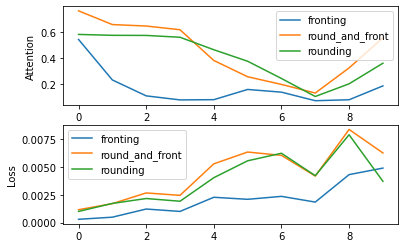

In [14]:
df_anl = df_mle[['group', 'Time', "Loss", "Attention"]].groupby(['group', 'Time']).mean()

figure_outputs, (attn_plot, loss_plot) = plt.subplots(2)

for grp in np.unique(df_mle['group']):
    attn_plot.plot(df_anl['Attention'][grp], label=grp)
    attn_plot.set_ylabel('Attention')
    loss_plot.plot(df_anl['Loss'][grp], label=grp)
    loss_plot.set_ylabel('Loss')

attn_plot.legend()
loss_plot.legend()


Time
0    0.464003
1    0.210205
2    0.100765
3    0.076474
4    0.078476
5    0.166885
6    0.150984
7    0.079308
8    0.079530
9    0.169848
Name: Attention, dtype: float64


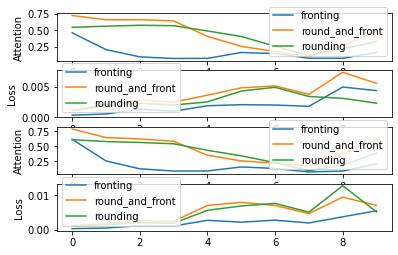

In [15]:
df_anl = df_mle[['group', 'Time', "V2", "Loss", "Attention"]].groupby(['group', "V2", 'Time']).mean()

print(df_anl['Attention']["fronting"]["H"])

figure_outputs, (attn_plot, loss_plot, attn_plot2, loss_plot2) = plt.subplots(4)

for grp in np.unique(df_mle['group']):
    attn_plot.plot(df_anl['Attention'][grp]["H"], label=grp)
    attn_plot.set_ylabel('Attention')
    loss_plot.plot(df_anl['Loss'][grp]["H"], label=grp)
    loss_plot.set_ylabel('Loss')
    attn_plot2.plot(df_anl['Attention'][grp]["L"], label=grp)
    attn_plot2.set_ylabel('Attention')
    loss_plot2.plot(df_anl['Loss'][grp]["L"], label=grp)
    loss_plot2.set_ylabel('Loss')

attn_plot.legend()
loss_plot.legend()
attn_plot2.legend()
loss_plot2.legend()

### Mixed linear effect models for each group

In [16]:
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison

''' From paper:
We used the identity of input V2 as 
    - either a high harmony trigger (/i, u/) 
      or a non-high non-trigger
    - and decoder timepoint as main factors, 
    - model as a random factor, 
    - and the attention value assigned to the encoder hidden state 
        associated with input V2 as the dependent variable.

This result suggests that the
decoder learns to pay more attention to a V2 at an
earlier timepoint when that V2 is a harmony trigger,
consistent with the representation of an anticipatory
(early-activating) gesture assumed by the Gestural
Harmony Model.
'''

# first fit a mixed linear model for each group

# divide the df into groups
df_last5 = df_mle[df_mle['Time'] > 4]

rounding_df = df_last5[df_last5['group'] == 'rounding']
fronting_df = df_last5[df_last5['group'] == 'fronting']
two_way_df = df_last5[df_last5['group'] == 'round_and_front']
grouped_dfs = [rounding_df, fronting_df, two_way_df]

# perform an MLE on each group
linear_models = []
for grp in grouped_dfs:
  # model training 
  md = smf.mixedlm("Attention ~ Time + V2 + fronted + rounded + high", grp, groups=grp["model"])
  mdf = md.fit(reml=False)
  linear_models.append(mdf)
  print(f"{grp['group'].values[0]} results:")
  print(mdf.summary())

  # # tukey HSD
  mc = MultiComparison(grp['Attention'], groups=grp['V2'])
  print(mc.tukeyhsd().summary())

/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


rounding results:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Attention
No. Observations: 4800    Method:             ML       
No. Groups:       20      Scale:              0.0687   
Min. group size:  240     Log-Likelihood:     -413.0472
Max. group size:  240     Converged:          Yes      
Mean group size:  240.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.293    0.027 10.960 0.000  0.241  0.346
V2[T.L]      -0.021    0.008 -2.796 0.005 -0.036 -0.006
fronted[T.1]  0.052    0.008  6.849 0.000  0.037  0.067
rounded[T.1] -0.011    0.009 -1.152 0.249 -0.029  0.007
high[T.1]     0.006    0.011  0.577 0.564 -0.015  0.027
Time         -0.007    0.003 -2.630 0.009 -0.012 -0.002
Group Var     0.006    0.007                           

Multiple Comparison of Means - Tukey H

/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
     H      L   0.0017 0.7653 -0.0095 0.013  False
--------------------------------------------------
round_and_front results:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Attention
No. Observations: 4800    Method:             ML       
No. Groups:       20      Scale:              0.0658   
Min. group size:  240     Log-Likelihood:     -315.0817
Max. group size:  240     Converged:          Yes      
Mean group size:  240.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.257    0.028 -9.105 0.000 -0.313 -0.202
V2[T.L]       0.069    0.007  9.263 0.000  0.054  0.083
fronted[T.1]  0.066    0.007  8.868 0.000  0.051  0.080


/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     H      L   0.0686   0.0 0.0521 0.0851   True
-------------------------------------------------


### Compare BIC

In [17]:
# compare model BIC
for m, grp in zip(linear_models, grouped_dfs):
    print(f"{grp['group'].values[0]} BIC: {m.bic}")

rounding BIC: 893.9052749465824
fronting BIC: -2394.9965913702495
round_and_front BIC: 697.9743288480219


### Compare attention across groups (one model)

In [18]:
# one mixed linear effects model
md = smf.mixedlm("Attention ~ Time + group * V2", df_last5, groups=df_last5["model"])
mdf = md.fit()
print(mdf.summary())

## tukey HSD
mc = MultiComparison(df_last5['Attention'], groups=df_last5['group'])
print(mc.tukeyhsd().summary())

/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Attention
No. Observations:         14400         Method:                   REML     
No. Groups:               60            Scale:                    0.0599   
Min. group size:          240           Log-Likelihood:           -283.4428
Max. group size:          240           Converged:                Yes      
Mean group size:          240.0                                            
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.020    0.021 -0.972 0.331 -0.062  0.021
group[T.round_and_front]          0.130    0.026  5.009 0.000  0.079  0.182
group[T.rounding]                 0.140    0.026  5.373 0.000  0.089  0.191
V2[T.L]                        

### Compare loss across groups (ANOVA)

In [19]:
# one mixed linear effects model
md = smf.mixedlm("Loss ~ Time + group * V2", df_last5, groups=df_last5["model"])
mdf = md.fit()
print(mdf.summary())

## tukey HSD
mc = MultiComparison(df_last5['Loss'], groups=df_last5['group'])
print(mc.tukeyhsd().summary())

/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Loss      
No. Observations:       14400         Method:                   REML      
No. Groups:             60            Scale:                    0.0000    
Min. group size:        240           Log-Likelihood:           51272.3780
Max. group size:        240           Converged:                No        
Mean group size:        240.0                                             
--------------------------------------------------------------------------
                                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.001    0.001  2.349 0.019  0.000  0.002
group[T.round_and_front]         0.002    0.001  3.785 0.000  0.001  0.003
group[T.rounding]                0.001    0.001  0.939 0.348 -0.001  0.002
V2[T.L]                          0.000    0.